# Functions for Processing
----

#### Note


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json as js
from scipy.stats import linregress
from collections import Counter 

# Import API key - usng CBS keys - not used yet
#from api_keys import sport_key

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy

# Input test file (JSON)
input_data_file='events.json'
# Output File (CSV)
output_data_file = "../output_data/eventsMaster.csv"


## Generate Events listing

In [3]:
with open(input_data_file) as f:
  data = js.load(f)
#gives a dictionary
#data.values()


In [4]:
import pprint
pp = pprint.PrettyPrinter(depth=4)



Need: 
'count'  - gives the number of events in the list
nested in 'count'
'events' - nested
 by 'contenttype'
     'eventstate' 'scheduled'
     'eventstatus' 'live'
     'eventtype' 'game'
     'is_passthrough' 'False'
     'prismid': '27a62c10-4a15-42ae-a81b-9b31c346ffb9',  [unique id]
     'schedule': {'endtimestamp': 1618181100,
                          'starttimebuffer': 0,
                          'starttimestamp': 1618163100},
     'school': 'nwst',
     'school_name': 'Northwestern State University',
     'sport': 'm-basebl',
     'sport_name': 'Baseball',



### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
#another way to print

#pp.pprint(f'Dictionary comprehension: {data}')

In [5]:
data.keys()

dict_keys(['events', 'count'])

In [7]:
newDict={}
print(data['count'])
newCount=0
#filter out the passthrough records
Counts=data['count']
#first look for passthrough = True
for index in range(1,Counts):
    if data['events'][index]['is_passthrough']==False:
        newDict=data
        newCount= newCount+1
    
#print(newDict)    
#print(f'filtered data counts {newCount}')

706


In [8]:
ID=[]
Type=[]
Scheduled=[]
Status=[]
CType=[]
Pass=[]
Start=[]
End=[]
Event_Title=[]
School_Name=[]
School_Code=[]
Game=[]
PubPoint=[]


for index in range(1,newCount):
    try:
        ID.append(newDict['events'][index]['prismid'])
        Type.append(newDict['events'][index]['eventtype'])
        Scheduled.append(newDict['events'][index]['eventstate'])
        Status.append(newDict['events'][index]['eventstatus'])
        #CType.append(newDict['events'][index]['contenttype'])
        Pass.append(newDict['events'][index]['is_passthrough'])
        Start.append(newDict['events'][index]['starttime'])
        End.append(newDict['events'][index]['endtime'])
        Event_Title.append(newDict['events'][index]['eventtitle'])
        School_Name.append(newDict['events'][index]['school_name'])
        School_Code.append(newDict['events'][index]['school'])
        Game.append(newDict['events'][index]['sport_name'])
        #PubPoint.append(newDict['events'][index]['ingest']['primary']['pub_point'])
    except ValueError:
        continue
    except KeyError:
        print(index)
        continue
             
        
  
    
event_df=pd.DataFrame(ID)
event_df['Event type']=Type
event_df['Scheduled']=Scheduled
event_df['Is Live']=Status
#event_df['Content Type']=CType
event_df['PassThru']=Pass
event_df['Start Time']=Start
event_df['End Time']=End
event_df['Event']=Event_Title
event_df['School Name']=School_Name
event_df['School Code']=School_Code
event_df['Sport']=Game
#event_df['Access Point']=PubPoint
event_df.rename(columns={0:'ID'},inplace=True)
event_df.set_index('ID',inplace=True)



In [9]:
#event_df

In [13]:
event_df.columns

Index(['Event type', 'Scheduled', 'Is Live', 'PassThru', 'Start Time',
       'End Time', 'Event', 'School Name', 'School Code', 'Sport'],
      dtype='object')

In [14]:
#output dataframe to CSV file
#event_df.to_csv('events.csv')

In [15]:
#process for location lat/lng by School Name
#from api_keys import g_key

#school locations to come later this week

In [16]:
import datetime

count=[]
x=0
        #read in start and end epoch times convert to integer and append to new list
Start3=list(map(int, Start))   
End3=list(map(int, End))
        #convert epoch times to datetime for readability
y=len(Start)
for x in range(len(Start)):
    Start3[x]=datetime.datetime.fromtimestamp(Start3[x])
    End3[x]=datetime.datetime.fromtimestamp(End3[x])
            #counter for Index ID in dataframe
    count.append(x)
        #create new dataframe for event start and end datetimes
active_runtime_df= pd.DataFrame(count)  
Start2=list(map(int, Start))   
End2=list(map(int, End))
active_runtime_df['epochStart']= pd.DataFrame(Start2)
active_runtime_df['epochEnd']= pd.DataFrame(End2)
    #active_runtime_df['Start']= datetime.datetime.fromtimestamp(Start)  
active_runtime_df['Start']= pd.DataFrame(Start3)
    #active_runtime_df['End']= datetime.datetime.fromtimestamp(End)   
active_runtime_df['End']= pd.DataFrame(End3)

In [17]:
        #sort datafrane by earliest Start
active_runtime_df = active_runtime_df.sort_values(by="Start")
#active_runtime_df

In [18]:
import pandas as pd
from io import StringIO
        #split start and end datetimes to Date and Time columns
active_runtime_df['Start Date'], active_runtime_df['Start Time'] = active_runtime_df['Start'].dt.date, active_runtime_df['Start'].dt.time
active_runtime_df['End Date'], active_runtime_df['End Time'] = active_runtime_df['End'].dt.date, active_runtime_df['End'].dt.time

#print(active_runtime_df)

In [19]:
        #Weekly break down of how many events per day
dates=[]
dates=active_runtime_df['Start Date'].unique()
daycount= active_runtime_df.pivot_table(index = ['Start Date'], aggfunc ='size')
#daycount
#rough count of events per day, not including events that run into next day

<BarContainer object of 6 artists>

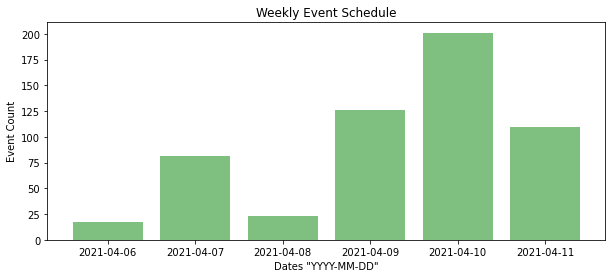

In [20]:
        #create bar graph of weekly breakdown
x_axis =dates
plt.figure(figsize=(10,4))
plt.title('Weekly Event Schedule')
plt.ylabel('Event Count')
plt.xlabel('Dates "YYYY-MM-DD"')
plt.bar(x_axis, daycount, color='g', alpha=.5, align="center")

In [21]:
import datetime

        #pull in user specific date to get daily breakdown by hour of day
date_entry= input('Enter a date in YYYY-MM-DD format ')
        #convert user date into datetime
year, month, day = map(int, date_entry.split('-'))
date1 = datetime.date(year, month, day)
#print(date1)
        #Convert datetime to epoch timestamp
from datetime import datetime
datetime1 = datetime(date1.year, date1.month, date1.day)
epoch_datetime = datetime1.timestamp()
#epoch time current date to midnight add 86400 for end of day
#for x=epoch starttime to y=epochendtime
    #resolutionvariable (24*60*60\(60*60)


Enter a date in YYYY-MM-DD format 2021-04-10


In [26]:

import datetime
count=[]
timepoints=[]
i=0

x=int(epoch_datetime)
q=int(epoch_datetime+86400)
#print(x)
j=0
            #compare each starttime in epoch to current epoch hour of given day
            #add to count if between starttime and endtime for each row that applies
            #append that count to hourly list and interate to next hour of the day
for i in range(24):
    timepoints.append(i+1)
    b=0
    for index, row in active_runtime_df.iterrows():
        date2=row['Start Date']
        if date2==date1:
                #num1=str(row['Start'])
                #print(num1)
                #format = "%Y-%m-%d %H:%M:%S"
                #datetime1 = datetime.datetime.strptime(num1, format)
                #num2=str(row['End'])
                #datetime2 = datetime.datetime.strptime(num2, format)
                #print(type(datetime1))
                #starttime1=datetime1.timestamp()
            starttime1=row['epochStart']
                #print(type(starttime1))
                #endtime1=datetime2.timestamp()
            endtime1=row['epochEnd']
            begin=int(starttime1)
            ending=int(endtime1)
            if x>=row['epochStart'] and x<=row['epochEnd']:
                b+=1
                #print(b)
    count.append(b)
    x=x+3600
    #print(x)
#print(count[20])

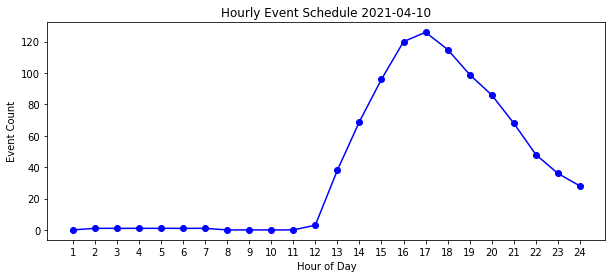

In [28]:
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

        #create line graph of daily breakdown by hour
plt.figure(figsize=(10,4))
plt.xticks(timepoints)
plt.title('Hourly Event Schedule '+str(date1))
plt.ylabel('Event Count')
plt.xlabel('Hour of Day')
plt.plot(timepoints, count, color='blue', marker='o')

plt.show()